# ATLAS Visualization — IEEE Publication Quality

This notebook generates publication-ready plots from ATLAS experimental results.

## Structure:
1. **Setup & Data Loading** (exclude results/statistical, old, archive)
2. **Lambda/Eta Sweep Analysis** — Compare different regularization strengths
3. **Multi-Seed Statistical Analysis** — Variance across random seeds  
4. **Method Comparison** — ATLAS vs FedAvg vs baselines
5. **Export** — Save figures and LaTeX tables


# ATLAS — Advanced Visualization Notebook
# Focus: advanced publication-quality comparisons; exclude results/statistical

# Notebook Outline:
# 1) Imports & setup
# 2) Find/load results (exclude old/archive/statistical)
# 3) Parse filenames into config+seed and normalize
# 4) Tidy DataFrames (round-level & client-level)
# 5) Summary metrics
# 6) Advanced plots: convergence with CI bands, violin+swarm final acc, per-client heatmap, comm vs acc regression
# 7) Save figures and package
# 8) Optional interactive selectors


In [18]:
# 1. Setup & Imports
import json
import re
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from IPython.display import display, Markdown

# IEEE-style plotting
plt.rcParams.update({
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'font.size': 11,
    'axes.titlesize': 12,
    'axes.labelsize': 11,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 13,
    'lines.linewidth': 2,
    'lines.markersize': 6
})

RESULTS_DIR = Path('results')
FIG_DIR = RESULTS_DIR / 'figures'
FIG_DIR.mkdir(parents=True, exist_ok=True)

print(f'Results directory: {RESULTS_DIR}')
print(f'Figures directory: {FIG_DIR}')


Results directory: results
Figures directory: results\figures


In [20]:
# 3. Parse filenames to extract: method, eta, seed, model
# Filename patterns:
# - atlas_integrated_full_atlas_00_eta_seed42.json -> method=atlas, eta=0.0, seed=42
# - atlas_integrated_full_atlas_05_eta_seed42.json -> method=atlas, eta=0.5, seed=42  
# - atlas_integrated_full_atlas_distilbert_seed123.json -> method=atlas, eta=None, seed=123, model=distilbert

def parse_filename(path: Path):
    """Extract experiment parameters from filename."""
    name = path.stem
    
    # Extract seed
    seed_match = re.search(r'seed(\d+)', name, re.IGNORECASE)
    seed = seed_match.group(1) if seed_match else 'unknown'
    
    # Extract eta (encoded as _00_eta, _01_eta, _05_eta, _10_eta for 0.0, 0.1, 0.5, 1.0)
    eta_match = re.search(r'_(\d+)_eta', name, re.IGNORECASE)
    if eta_match:
        eta_code = eta_match.group(1)
        # Convert: 00->0.0, 01->0.1, 05->0.5, 10->1.0
        eta = float(eta_code) / 10.0 if len(eta_code) == 2 else float(eta_code) / 100.0
    else:
        eta = None  # default configuration
    
    # Extract model
    model = 'distilbert'  # default
    if 'gpt2-xl' in name.lower():
        model = 'gpt2-xl'
    elif 'gpt2' in name.lower():
        model = 'gpt2'
    elif 'roberta' in name.lower():
        model = 'roberta'
    elif 'distilbert' in name.lower():
        model = 'distilbert'
    
    # Extract method (atlas, fedavg_cluster, local_only, etc.)
    if 'fedavg_cluster' in name.lower() or 'fedavg-cluster' in name.lower():
        method = 'fedavg_cluster'
    elif 'local_only' in name.lower() or 'local-only' in name.lower():
        method = 'local_only'
    elif 'atlas' in name.lower():
        method = 'atlas'
    else:
        method = 'unknown'
    
    return method, eta, seed, model

# Test parsing
print('\\nFilename parsing test:')
for f in result_files[:5]:
    method, eta, seed, model = parse_filename(f)
    eta_str = f'{eta:.2f}' if eta is not None else 'default'
    print(f'  {f.name:50s} -> method={method:15s} eta={eta_str:8s} seed={seed:4s} model={model}')


\nFilename parsing test:
  atlas_integrated_full_atlas_00_eta_seed42.json     -> method=atlas           eta=0.00     seed=42   model=distilbert
  atlas_integrated_full_atlas_01_eta_seed42.json     -> method=atlas           eta=0.10     seed=42   model=distilbert
  atlas_integrated_full_atlas_05_eta_seed42.json     -> method=atlas           eta=0.50     seed=42   model=distilbert
  atlas_integrated_full_atlas_distilbert_seed123.json -> method=atlas           eta=default  seed=123  model=distilbert
  atlas_integrated_full_atlas_distilbert_seed42.json -> method=atlas           eta=default  seed=42   model=distilbert


In [21]:
# 4. Load ALL data from result files
round_rows = []
final_rows = []

for fpath in result_files:
    try:
        with open(fpath, 'r') as f:
            data = json.load(f)
    except Exception as e:
        print(f'Error loading {fpath.name}: {e}')
        continue
    
    method, eta, seed, model = parse_filename(fpath)
    
    # Extract round-by-round metrics
    for rm in data.get('round_metrics', []):
        # Communication bytes
        up_bytes = rm.get('comm_upload_bytes', 0)
        down_bytes = rm.get('comm_download_bytes', 0)
        if isinstance(up_bytes, dict):
            up_bytes = sum(up_bytes.values())
        if isinstance(down_bytes, dict):
            down_bytes = sum(down_bytes.values())
        
        # Average accuracy
        avg_acc = rm.get('avg_accuracy')
        if avg_acc is None and 'client_accuracies' in rm:
            avg_acc = np.mean(list(rm['client_accuracies'].values()))
        
        round_rows.append({
            'method': method,
            'eta': eta,
            'seed': seed,
            'model': model,
            'round': rm.get('round'),
            'avg_accuracy': avg_acc,
            'comm_mb': (up_bytes + down_bytes) / (1024**2),
            'time_sec': rm.get('time_seconds'),
            'file': fpath.name
        })
    
    # Extract final client accuracies
    for client_id, acc in data.get('final_accuracies', {}).items():
        final_rows.append({
            'method': method,
            'eta': eta,
            'seed': seed,
            'model': model,
            'client_id': str(client_id),
            'accuracy': acc,
            'file': fpath.name
        })

round_df = pd.DataFrame(round_rows)
final_df = pd.DataFrame(final_rows)

print(f'\\nLoaded data:')
print(f'  Round-level metrics: {len(round_df)} rows')
print(f'  Final client accuracies: {len(final_df)} rows')
print(f'\\nDataFrame preview:')
display(round_df.head())
display(final_df.head())


\nLoaded data:
  Round-level metrics: 60 rows
  Final client accuracies: 54 rows
\nDataFrame preview:


,method,eta,seed,model,round,avg_accuracy,comm_mb,time_sec,file
0,atlas,0.0,42,distilbert,1,0.737209,109.84584,71.357235,atlas_integrated_full_atlas_00_eta_seed42.json
1,atlas,0.0,42,distilbert,2,0.763581,109.84584,72.297852,atlas_integrated_full_atlas_00_eta_seed42.json
2,atlas,0.0,42,distilbert,3,0.770784,109.84584,72.739427,atlas_integrated_full_atlas_00_eta_seed42.json
3,atlas,0.0,42,distilbert,4,0.775618,109.84584,72.537965,atlas_integrated_full_atlas_00_eta_seed42.json
4,atlas,0.0,42,distilbert,5,0.781880,109.84584,72.951180,atlas_integrated_full_atlas_00_eta_seed42.json


,method,eta,seed,model,client_id,accuracy,file
0,atlas,0.0,42,distilbert,0,0.866972,atlas_integrated_full_atlas_00_eta_seed42.json
1,atlas,0.0,42,distilbert,1,0.866972,atlas_integrated_full_atlas_00_eta_seed42.json
2,atlas,0.0,42,distilbert,2,0.862385,atlas_integrated_full_atlas_00_eta_seed42.json
3,atlas,0.0,42,distilbert,3,0.759804,atlas_integrated_full_atlas_00_eta_seed42.json
4,atlas,0.0,42,distilbert,4,0.752451,atlas_integrated_full_atlas_00_eta_seed42.json


In [22]:
# 5. Data Summary
print('\\n' + '='*80)
print('EXPERIMENT SUMMARY')
print('='*80)

print('\\nMethods:', round_df['method'].unique())
print('Eta values:', sorted([x for x in round_df['eta'].unique() if x is not None]))
print('Seeds:', sorted(round_df['seed'].unique()))
print('Models:', round_df['model'].unique())

print('\\nExperiment breakdown:')
for (method, eta, model), group in round_df.groupby(['method', 'eta', 'model']):
    seeds = group['seed'].unique()
    rounds = group['round'].nunique()
    eta_str = f'eta={eta:.2f}' if eta is not None else 'eta=default'
    print(f'  {method:15s} {eta_str:12s} {model:10s} -> {len(seeds)} seed(s), {rounds} rounds')


\n================================================================================
EXPERIMENT SUMMARY
\nMethods: ['atlas']
Eta values: [0.0, 0.1, 0.5, nan]
Seeds: ['123', '42', '456']
Models: ['distilbert']
\nExperiment breakdown:
  atlas           eta=0.00     distilbert -> 1 seed(s), 10 rounds
  atlas           eta=0.10     distilbert -> 1 seed(s), 10 rounds
  atlas           eta=0.50     distilbert -> 1 seed(s), 10 rounds


## Lambda/Eta Sweep Analysis

Compare different regularization strengths (eta/lambda values) for the same method and model.


C:\Users\Hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\axes\_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
C:\Users\Hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\axes\_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


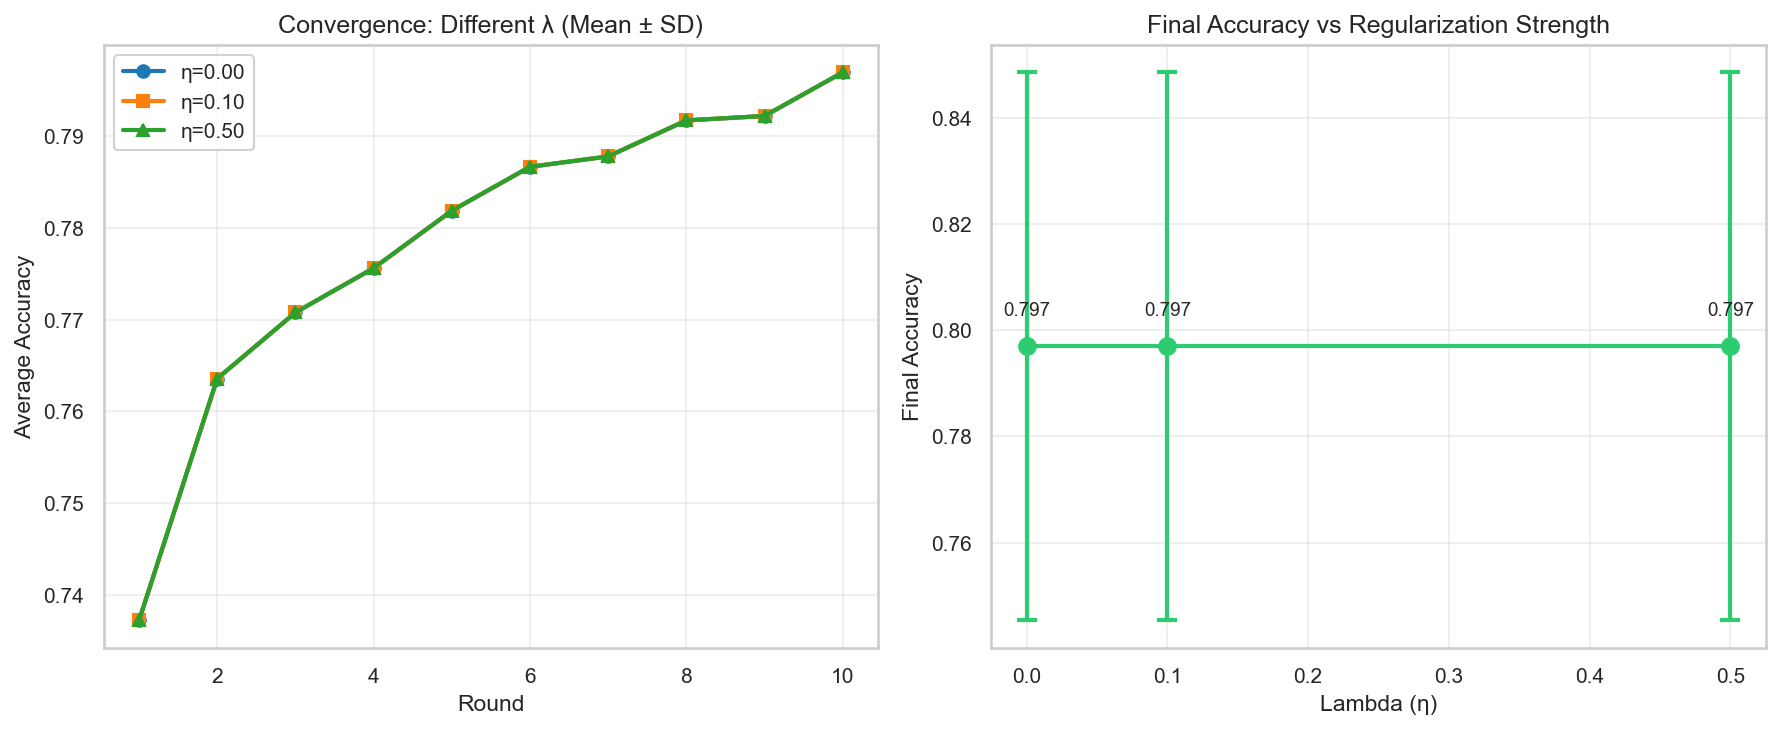

\nLambda Sweep Results:


,eta,mean_acc,std_acc,count
0,0.0,0.796957,0.051643,9
1,0.1,0.796957,0.051643,9
2,0.5,0.796957,0.051643,9


In [23]:
# 6. Lambda Sweep: Convergence Curves
# Filter for eta sweep experiments (where eta is not None)
eta_sweep_df = round_df[round_df['eta'].notna()].copy()

if len(eta_sweep_df) > 0:
    # Group by eta and compute mean/std across seeds for each round
    eta_groups = eta_sweep_df.groupby(['eta', 'round']).agg(
        mean_acc=('avg_accuracy', 'mean'),
        std_acc=('avg_accuracy', 'std'),
        count=('avg_accuracy', 'count')
    ).reset_index()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot 1: Convergence curves with error bars
    markers = ['o', 's', '^', 'v', 'D', 'p']
    colors = plt.cm.tab10(np.linspace(0, 1, 10))
    
    for i, (eta_val, group) in enumerate(eta_groups.groupby('eta')):
        color = colors[i % len(colors)]
        marker = markers[i % len(markers)]
        
        # Plot mean with error bars every N rounds to avoid clutter
        step = max(1, len(group) // 8)
        plot_idx = list(range(0, len(group), step))
        
        ax1.plot(group['round'], group['mean_acc'], 
                marker=marker, markevery=step, 
                label=f'η={eta_val:.2f}', 
                color=color, linewidth=2)
        
        # Add error bars at selected points
        if len(plot_idx) > 0:
            subset = group.iloc[plot_idx]
            ax1.errorbar(subset['round'], subset['mean_acc'], 
                        yerr=subset['std_acc'],
                        fmt='none', ecolor=color, alpha=0.4, capsize=3)
    
    ax1.set_xlabel('Round')
    ax1.set_ylabel('Average Accuracy')
    ax1.set_title('Convergence: Different λ (Mean ± SD)')
    ax1.legend(loc='best', framealpha=0.9)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Final accuracy vs eta
    final_eta = final_df[final_df['eta'].notna()].groupby('eta').agg(
        mean_acc=('accuracy', 'mean'),
        std_acc=('accuracy', 'std'),
        count=('accuracy', 'count')
    ).reset_index()
    
    ax2.errorbar(final_eta['eta'], final_eta['mean_acc'], 
                yerr=final_eta['std_acc'],
                fmt='o-', capsize=5, capthick=2, linewidth=2, 
                markersize=8, color='#2ecc71')
    
    ax2.set_xlabel('Lambda (η)')
    ax2.set_ylabel('Final Accuracy')
    ax2.set_title('Final Accuracy vs Regularization Strength')
    ax2.grid(True, alpha=0.3)
    
    # Annotate points
    for _, row in final_eta.iterrows():
        ax2.text(row['eta'], row['mean_acc'] + 0.005, 
                f"{row['mean_acc']:.3f}", 
                ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(FIG_DIR / 'lambda_sweep_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print('\\nLambda Sweep Results:')
    display(final_eta)
else:
    print('No eta sweep experiments found')


## Multi-Seed Statistical Analysis

Analyze variance across different random seeds (statistical rigor).


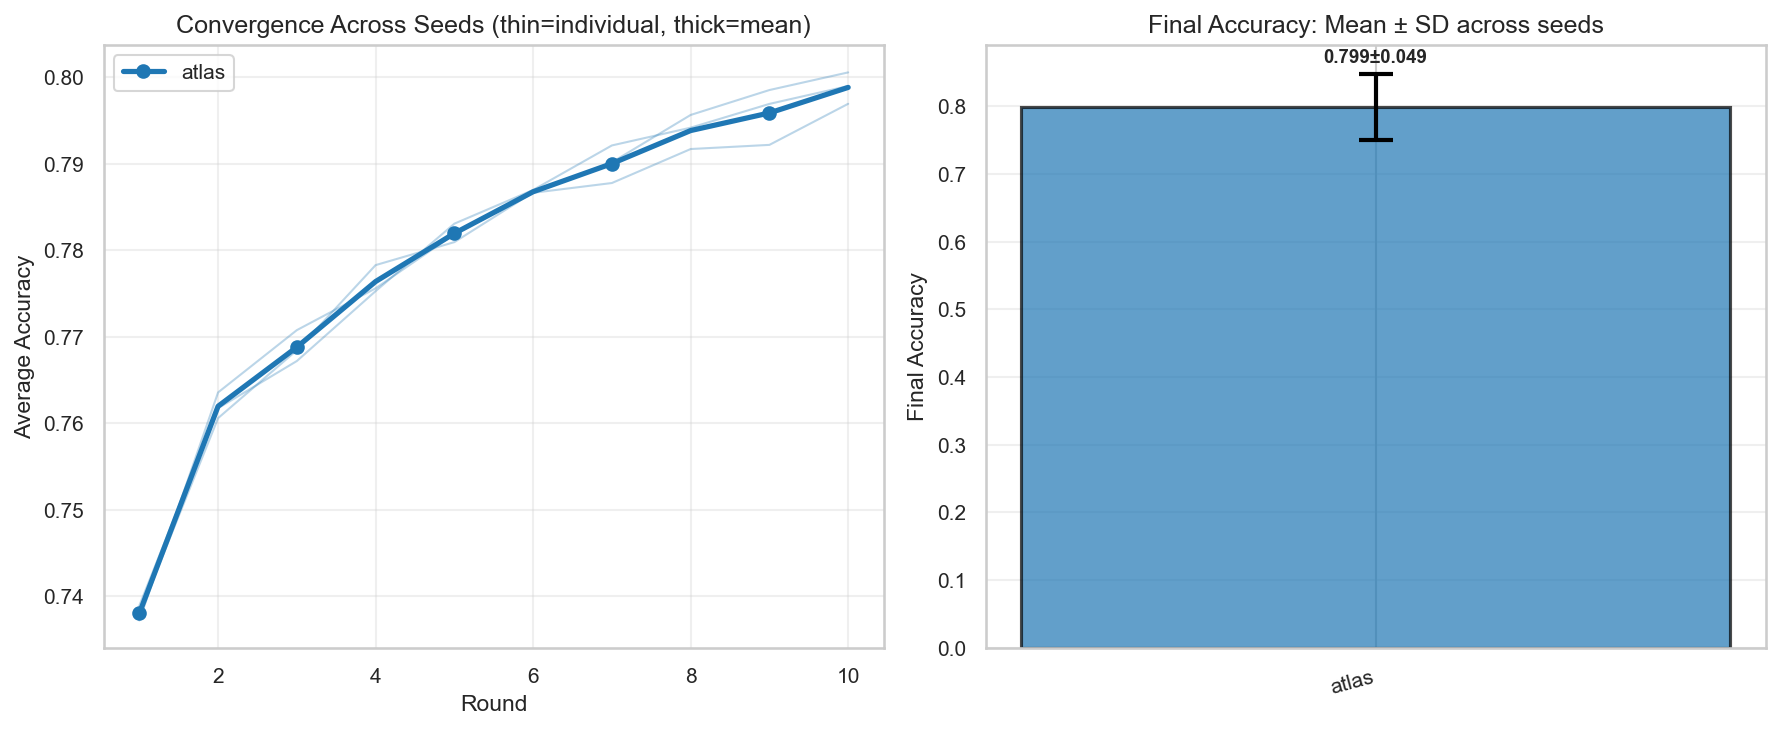

\nMulti-Seed Statistics:
atlas               : 0.7989 ± 0.0493 (n=27 clients across seeds)


In [24]:
# 7. Multi-Seed Analysis: Show variance across seeds for each method
# Filter for experiments with same method but different seeds
seed_analysis_df = round_df[round_df['eta'].isna()].copy()  # Use default eta experiments

if len(seed_analysis_df) > 0:
    # Group by method and round, show individual seed trajectories
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    methods = seed_analysis_df['method'].unique()
    colors = plt.cm.tab10(np.linspace(0, 1, len(methods)))
    
    # Plot 1: All seed trajectories (thin lines) + mean (thick line)
    ax = axes[0]
    for i, method in enumerate(methods):
        method_data = seed_analysis_df[seed_analysis_df['method'] == method]
        
        # Plot individual seeds as thin lines
        for seed in method_data['seed'].unique():
            seed_data = method_data[method_data['seed'] == seed]
            ax.plot(seed_data['round'], seed_data['avg_accuracy'], 
                   alpha=0.3, linewidth=1, color=colors[i])
        
        # Plot mean as thick line
        mean_data = method_data.groupby('round')['avg_accuracy'].mean()
        ax.plot(mean_data.index, mean_data.values, 
               label=method, linewidth=2.5, color=colors[i], marker='o', markevery=2)
    
    ax.set_xlabel('Round')
    ax.set_ylabel('Average Accuracy')
    ax.set_title('Convergence Across Seeds (thin=individual, thick=mean)')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Final accuracy distribution across seeds
    ax = axes[1]
    final_seed_data = final_df[final_df['eta'].isna()].copy()
    
    for i, method in enumerate(methods):
        method_finals = final_seed_data[final_seed_data['method'] == method]['accuracy']
        if len(method_finals) > 0:
            # Compute statistics
            mean_acc = method_finals.mean()
            std_acc = method_finals.std()
            
            # Plot mean with error bar
            ax.bar(i, mean_acc, color=colors[i], alpha=0.7, edgecolor='black', linewidth=1.5)
            ax.errorbar(i, mean_acc, yerr=std_acc, fmt='none', 
                       color='black', capsize=8, capthick=2, linewidth=2)
            
            # Annotate
            ax.text(i, mean_acc + std_acc + 0.01, 
                   f'{mean_acc:.3f}±{std_acc:.3f}',
                   ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    ax.set_xticks(range(len(methods)))
    ax.set_xticklabels(methods, rotation=15, ha='right')
    ax.set_ylabel('Final Accuracy')
    ax.set_title('Final Accuracy: Mean ± SD across seeds')
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(FIG_DIR / 'multi_seed_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print statistics
    print('\\nMulti-Seed Statistics:')
    for method in methods:
        method_finals = final_seed_data[final_seed_data['method'] == method]['accuracy']
        if len(method_finals) > 0:
            print(f'{method:20s}: {method_finals.mean():.4f} ± {method_finals.std():.4f} (n={len(method_finals)} clients across seeds)')
else:
    print('No multi-seed experiments found')


## Method Comparison

ATLAS vs FedAvg vs baselines — IEEE publication table and plots.


\n================================================================================
METHOD COMPARISON TABLE


,Method,Final Acc,Std Dev,Comm (MB),Time (min),Rounds,Seeds
0,atlas,0.7989,0.0493,1132.2,12.1,10,3


\nLaTeX table saved to: results\comparison_table.tex


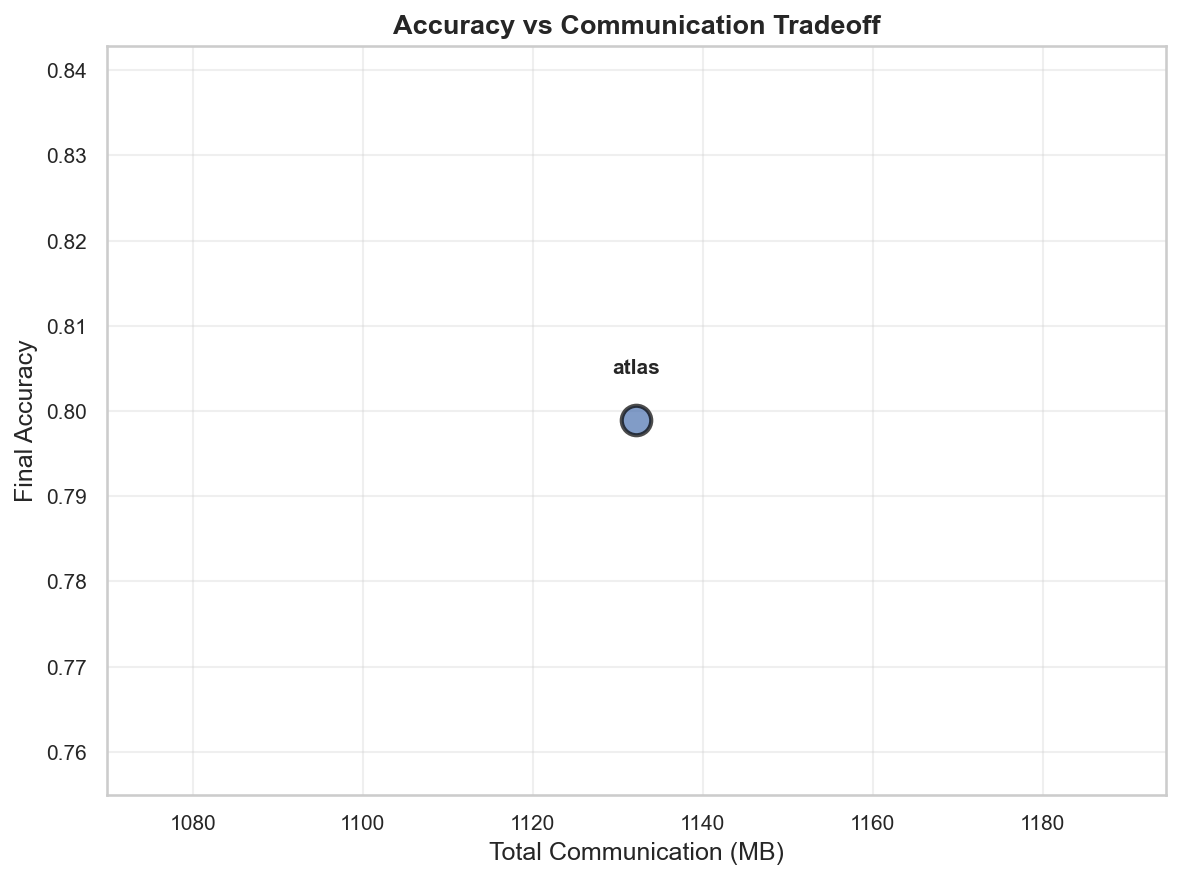

In [25]:
# 8. Method Comparison Table
comparison_df = round_df[round_df['eta'].isna()].copy()

if len(comparison_df) > 0:
    # Compute comprehensive statistics per method
    results = []
    for method in comparison_df['method'].unique():
        method_round_data = comparison_df[comparison_df['method'] == method]
        method_final_data = final_df[(final_df['method'] == method) & (final_df['eta'].isna())]
        
        # Metrics
        final_acc_mean = method_final_data['accuracy'].mean()
        final_acc_std = method_final_data['accuracy'].std()
        total_comm_mb = method_round_data.groupby('seed')['comm_mb'].sum().mean()
        total_time_min = method_round_data.groupby('seed')['time_sec'].sum().mean() / 60.0
        n_rounds = method_round_data['round'].nunique()
        n_seeds = method_round_data['seed'].nunique()
        
        results.append({
            'Method': method,
            'Final Acc': f'{final_acc_mean:.4f}',
            'Std Dev': f'{final_acc_std:.4f}',
            'Comm (MB)': f'{total_comm_mb:.1f}',
            'Time (min)': f'{total_time_min:.1f}' if not np.isnan(total_time_min) else 'N/A',
            'Rounds': n_rounds,
            'Seeds': n_seeds
        })
    
    comparison_table = pd.DataFrame(results)
    
    print('\\n' + '='*80)
    print('METHOD COMPARISON TABLE')
    print('='*80)
    display(comparison_table)
    
    # Export LaTeX table
    latex_lines = [
        '\\\\begin{table}[t]',
        '\\\\centering',
        '\\\\caption{Method Comparison (Mean $\\\\pm$ SD across seeds)}',
        '\\\\begin{tabular}{lcccc}',
        '\\\\toprule',
        'Method & Final Acc & Communication (MB) & Time (min) & Rounds \\\\\\\\',
        '\\\\midrule'
    ]
    
    for _, row in comparison_table.iterrows():
        acc = row['Final Acc']
        std = row['Std Dev']
        comm = row['Comm (MB)']
        time_val = row['Time (min)']
        rounds = row['Rounds']
        method_name = row['Method'].replace('_', '\\\\_')
        latex_lines.append(f'{method_name} & ${acc} \\\\pm {std}$ & {comm} & {time_val} & {rounds} \\\\\\\\')
    
    latex_lines.extend(['\\\\bottomrule', '\\\\end{tabular}', '\\\\end{table}'])
    
    latex_table = '\\n'.join(latex_lines)
    (RESULTS_DIR / 'comparison_table.tex').write_text(latex_table)
    print(f'\\nLaTeX table saved to: {RESULTS_DIR / "comparison_table.tex"}')
    
    # Create comparison plot: Accuracy vs Communication tradeoff
    fig, ax = plt.subplots(figsize=(8, 6))
    
    for _, row in comparison_table.iterrows():
        method = row['Method']
        acc = float(row['Final Acc'])
        comm = float(row['Comm (MB)'])
        
        ax.scatter(comm, acc, s=200, alpha=0.7, edgecolors='black', linewidth=2)
        ax.text(comm, acc + 0.005, method, ha='center', va='bottom', 
               fontsize=10, fontweight='bold')
    
    ax.set_xlabel('Total Communication (MB)', fontsize=12)
    ax.set_ylabel('Final Accuracy', fontsize=12)
    ax.set_title('Accuracy vs Communication Tradeoff', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(FIG_DIR / 'method_comparison_tradeoff.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print('No comparison data available')


## Export & Summary


In [ ]:
# 9. Export Summary
print('\\n' + '='*80)
print('EXPORT SUMMARY')
print('='*80)

# List generated figures
figures = sorted(FIG_DIR.glob('*.png'))
print(f'\\n Generated {len(figures)} figures in {FIG_DIR}:')
for fig in figures:
    print(f'  - {fig.name}')

# Save summary CSV
summary_rows = []
for method in round_df['method'].unique():
    for eta_val in [None] + sorted([x for x in round_df['eta'].unique() if x is not None]):
        subset_round = round_df[(round_df['method'] == method) & (round_df['eta'] == eta_val)]
        subset_final = final_df[(final_df['method'] == method) & (final_df['eta'] == eta_val)]
        
        if len(subset_final) > 0:
            summary_rows.append({
                'method': method,
                'eta': eta_val if eta_val is not None else 'default',
                'final_acc_mean': subset_final['accuracy'].mean(),
                'final_acc_std': subset_final['accuracy'].std(),
                'total_comm_mb': subset_round['comm_mb'].sum(),
                'n_seeds': subset_round['seed'].nunique(),
                'n_rounds': subset_round['round'].nunique()
            })

summary_df = pd.DataFrame(summary_rows)
summary_csv = RESULTS_DIR / 'visualization_summary.csv'
summary_df.to_csv(summary_csv, index=False)
print(f'\\nSaved summary: {summary_csv}')

# Create archive
import shutil
archive_name = RESULTS_DIR / 'publication_figures'
shutil.make_archive(str(archive_name), 'zip', FIG_DIR)
print(f'\\nCreated archive: {archive_name}.zip')

print('\\n' + '='*80)
print('VISUALIZATION COMPLETE')
print('='*80)
print('\\nNext steps:')
print('  1. Review figures in:', FIG_DIR)
print('  2. Check LaTeX table:', RESULTS_DIR / 'comparison_table.tex')
print('  3. Use archive for publication:', f'{archive_name}.zip')


---

## Usage Notes

**Requirements:**
```bash
pip install pandas numpy matplotlib seaborn scipy
```

**Structure:**
- **Lambda Sweep**: Compares different eta/lambda values (separate from seeds)
- **Multi-Seed Analysis**: Shows variance across random seeds (for statistical rigor)
- **Method Comparison**: ATLAS vs FedAvg vs baselines

**Outputs:**
- `results/figures/` — All PNG figures (300 DPI)
- `results/comparison_table.tex` — LaTeX table for IEEE paper
- `results/visualization_summary.csv` — Summary statistics
- `results/publication_figures.zip` — All figures packaged

**Note:** This notebook automatically excludes files in `results/statistical/`, `results/old/`, and `results/archive/` folders.
